## Explicit Euler scheme
Terminal condition: option's pay-off: $u(t_N,x_m) =
\tilde h(x_m)$, $\tilde h(x) = h(s_0 e^x)$.


Finite difference equation for $\hat u_{n,m}$ - backward resolution from $n=N$ to
$n=0$. 
\begin{align*}
&\hat u_{n-1,m} = \hat u_{n,m}\left\{1 - \frac{\tilde
  \sigma^2(t_n,x_m)\Delta t}{ \Delta x^2}\right\} + \hat u_{n,m+1}\frac{\tilde
  \sigma^2(t_n,x_m)\Delta t}{2 \Delta x^2}\left(1-\frac{\Delta
    x}{2}\right) \\ &\qquad +\hat u_{n,m-1}\frac{\tilde \sigma^2(t_n,x_m)\Delta t}{2 \Delta x^2}\left(1+\frac{\Delta x}{2}\right)\\
&\hat u_{n,0} = g(t_n,x_0),\  \hat u_{n,M} = g(t_n,x_M),\ \forall n;
  \quad \hat u_{N,m} = \tilde h(x_m),\ \forall m.
\end{align*}


## Implicit scheme
\begin{align*}
&\frac{\partial u(t_n,x_m)}{\partial t}\approx
\frac{u(t_{n+1},x_m)-u(t_{n},x_m)}{\Delta t},\quad 0\leq n \leq N-1\\
&\Rightarrow \quad \hat u_{n,m}= \hat u_{n-1,m} \left\{1+\frac{\tilde
  \sigma^2(t_{n-1},x_m)\Delta t}{ \Delta x^2}\right\} - \hat u_{{n-1},m+1}\frac{\tilde
  \sigma^2(t_{n-1},x_m)\Delta t}{2 \Delta x^2}\left(1-\frac{\Delta
    x}{2}\right) \\ &\qquad \qquad-
\hat u_{n-1,m-1}\frac{\tilde \sigma^2(t_{n-1},x_m)\Delta t}{2 \Delta x^2}\left(1+\frac{\Delta x}{2}\right). 
\end{align*}

In [24]:
# Packages
import numpy as np
from scipy.stats import norm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
class Euler_Scheme:

  def __init__(self, S0 = 100, sigmin = 0.1, sigmax = 0.4, Ntime = 100, Nspace = 100, A = 2):
    self.S0 = S0
    self.sigmin = sigmin
    self.sigmax = sigmax
    self.A = A
    self.Ntime = Ntime
    self.Nspace = Nspace

  @staticmethod
  def h(S, K):
    return np.max(S,K)

  def htil(self, x, K):
    return Euler_Scheme.h(self.S0*np.exp(x),K)

  def sigtil(self, x):
      return self.sigmin+(self.sigmax - self.sigmin) * (-np.arctan(3*x)+np.pi/2)/np.pi

  @staticmethod   
  def bsprice(S,K,T,r,sigma):
      d1 = (np.log(S/K)+(r+sigma*sigma/2.)*T)/(sigma*np.sqrt(T))
      d2 = d1-sigma*np.sqrt(T)
      return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
  
  def explicit(self,T, g, htil, sigtil):
    x = np.linspace(-self.A, self.A, self.Nspace + 1)
    t = np.linspace(0, T, self.Ntime + 1)
    u = np.zeros((self.Ntime + 1, self.Nspace+1))
    u[self.Ntime,:] = htil(x)
    dt = 1.*T/self.Ntime
    dx = 2.*self.A/self.Nspace
    p = sigtil(x[1:-1])**2*dt/2./dx**2*(1-dx/2.)
    q = sigtil(x[1:-1])**2*dt/2./dx**2*(1+dx/2.)
    print("Stability condition ",np.min(1.-p-q))
    for i in range(self.Ntime,0,-1):
        u[i-1,1:-1] = p*u[i,2:]+q*u[i,:-2] + (1.-p-q)*u[i,1:-1]
        u[i-1,0] = g(t[i-1],x[0])
        u[i-1,self.Nspace] = g(t[i-1],x[self.Nspace])
    return x,u

    
  def implicit(self, T, g, htil, sigtil):
      x = np.linspace(-self.A, self.A, self.Nspace + 1)
      t = np.linspace(0, T, self.Ntime + 1)
      u = np.zeros((self.Ntime + 1, self.Nspace + 1))
      u[self.Ntime,:] = htil(x)
      dt = 1.*T/self.Ntime
      dx = 2.*self.A/self.Nspace
      p = sigtil(x[1:-1])**2*dt/2./dx**2*(1-dx/2.)
      q = sigtil(x[1:-1])**2*dt/2./dx**2*(1+dx/2.)
      Amat = np.zeros((self.Nspace-1,self.Nspace-1))
      for i in range(self.Nspace-2):
          Amat[i,i] = 1.+p[i]+q[i]
          Amat[i,i+1] = -p[i]
          Amat[i+1,i] = -q[i+1]
      Amat[-1,-1] = 1.+p[-1]+q[-1]
      Ainv = np.linalg.inv(Amat)
      v = np.zeros(self.Nspace-1)
      for i in range(self.Ntime,0,-1):
          v[0] = -q[0]*g(t[i-1],x[0])
          v[-1] = -p[-1]*g(t[i-1],x[self.Nspace])
          u[i-1,1:-1] = np.dot(Ainv,u[i,1:-1]-v)
          u[i-1,0] = g(t[i-1],x[0])
          u[i-1,self.Nspace] = g(t[i-1],x[self.Nspace])
      return x,u    


scheme = Euler_Scheme()

Text(0, 0.5, 'sigma')

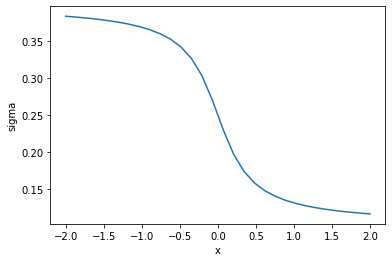

In [26]:
x = np.linspace(-2,2,30)
plt.plot(x,scheme.sigtil(x))
plt.xlabel('x')
plt.ylabel('sigma')

In [27]:
K= 100
T = 1.0
scheme_1 = Euler_Scheme(sigmin = 0.3, sigmax = 0.3, Ntime=100,Nspace=100 )
scheme_2 = Euler_Scheme(sigmin = 0.3, sigmax = 0.3, Ntime=1600,Nspace=400 )
scheme_3 = Euler_Scheme(sigmin = 0.3, sigmax = 0.3, Ntime=1600,Nspace=100 )

x1,u1 = scheme_1.explicit(T, lambda t,x:scheme_1.htil(x,K), lambda x:scheme_1.htil(x,K),
                 lambda x:scheme_1.sigtil(x))
x2,u2 = scheme_2.explicit(T, lambda t,x:scheme_2.htil(x,K), lambda x:scheme_2.htil(x,K),
                 lambda x:scheme_2.sigtil(x))
x3,u3 = scheme_3.explicit(T, lambda t,x:scheme_3.htil(x,K), lambda x:scheme_3.htil(x,K),
                 lambda x:scheme_3.sigtil(x))
bs = scheme_1.bsprice(scheme_1.S0*np.exp(x1),K,T,0.,scheme_1.sigmax)



Stability condition  0.4375
Stability condition  0.4375000000000001
Stability condition  0.96484375


Stability condition  -0.5574034705043451


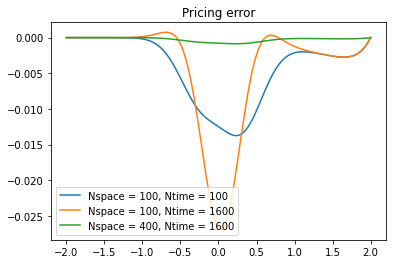

In [35]:

plt.plot(x1,u1[0,:]-bs,label='Nspace = 100, Ntime = 100')
plt.plot(x1,u3[0,:]-bs,label='Nspace = 100, Ntime = 1600')
plt.plot(x1,u2[0,::4]-bs,label='Nspace = 400, Ntime = 1600')
plt.legend()
plt.title('Pricing error')

scheme_comparison= Euler_Scheme(Ntime=100,Nspace=130)
x4,u4 = scheme_comparison.explicit(T, lambda t,x:scheme_comparison.htil(x,K), lambda x:scheme_comparison.htil(x,K),
                 lambda x:scheme_comparison.sigtil(x))
x5,u5 = scheme_comparison.implicit(T, lambda t,x:scheme_comparison.htil(x,K), lambda x:scheme_comparison.htil(x,K),
                 lambda x:scheme_comparison.sigtil(x))



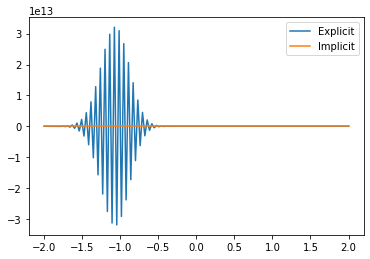

In [34]:
plt.plot(x4,u4[0,:],label='Explicit')
plt.plot(x5,u5[0,:],label='Implicit')
plt.legend()

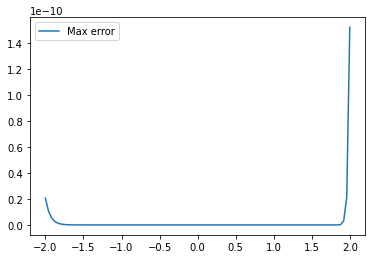

In [23]:
scheme_bound= Euler_Scheme(Ntime=100,Nspace=100)
x1,u1 = scheme_bound.implicit(T, lambda t,x:scheme_bound.htil(x,K), lambda x:scheme_bound.htil(x,K),
                 lambda x:scheme_bound.sigtil(x))
x2,u2 = scheme_bound.implicit(T, lambda t,x:scheme_bound.bsprice(S0*np.exp(x),K,T-t,0.,sigmax), lambda x:scheme_bound.htil(x,K),
                 lambda x:scheme_bound.sigtil(x))
plt.plot(x1,u2[0,:]-u1[0,:],label='Max error')
plt.legend()